<a href="https://colab.research.google.com/github/SiqiHuang18/ECE239as-Deep-learning/blob/ChrisZhang/CNN_B_200timeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
from google.colab import files
import torch
import torchvision 
import torchvision.transforms as transoforms
import torch.optim as optim
from load_data_200 import *
import torch.nn as nn
import torch.backends.cudnn as cudnn
import os 


%load_ext autoreload
%autoreload 2


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
# Data
print(device)
print('==> Preparing data..')
subject="ALL"
load=loader()

train_loader, test_loader,val_loader, _ = load(subject,batch_size= 20,num_validation = 30)

#cc = val_loader
#dd = test_loader
#val_loader = dd
#test_loader = cc

sub_num= 4 if subject=="ALL" else subject

cuda
==> Preparing data..
Train data shape:  (1845, 22, 200)
Train labels shape:  (1845,)
test data shape:  (261, 22, 200)
test labels shape:  (261,)
Validation data shape:  (270, 22, 200)
Validation labels shape:  (270,)


In [0]:
# Training 
def train(epoch):
    trainloader=train_loader
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Get the inputs
        inputs, labels = inputs.to(device), labels.to(device).long()
        inputs = inputs.to(device)        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward+Backward+Optimize
        outputs = net(inputs)
#         labels = labels.unsqueeze(1)
#         print('labels',labels.shape)
#         one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#         labels=one_hot.to(device)
#         print('outputs',outputs.shape) # Shape should be [20*4]
#         print('labels',labels.shape)
        loss = criterion (outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics 
        train_loss += loss.item()
        _,predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return ([train_loss/(batch_idx+1),100.*correct/total])

In [0]:
# Testing
def test(epoch,check_num,testloader=test_loader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    total_by_cat = np.zeros((sub_num))
    correct_by_cat = np.zeros((sub_num))


    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
#             inputs, labels = inputs.to(device), labels.to(device)
            inputs,labels = inputs.to(device), labels.to(device).long()

            outputs = net(inputs)
#             labels=labels.unsqueeze(1)
            
#             one_hot = torch.zeros(labels.shape[0], 4).scatter_(1, labels, 1)       
#             labels=one_hot.to(device)
            
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            for i, (pred, tar) in enumerate(zip(predicted, labels)):
                total_by_cat[tar.item()]+=1
                if(pred.item() == tar.item()):
                    correct_by_cat[tar.item()] += 1
            #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #    % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


    print('\nEpoch: %d | Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    np.set_printoptions(precision=3)
    print("Acc by class: ", correct_by_cat * 1.0 / total_by_cat)

    # Save checkpoint.
    acc = 100.*correct/total
    #if acc > best_acc:
    #    print('Saving..')
    #    state = {
    #        'net': net.state_dict(),
    #        'acc': acc,
    #        'epoch': epoch,
    #    }
    #    if not os.path.isdir('checkpoint'):
    #        os.mkdir('checkpoint')
    #    torch.save(state, './checkpoint/ckpt.t7')
    #    best_acc = acc
    is_check = None
    if acc >= 100.*0.7:
        is_check = True
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t' + str(check_num))
        check_num = check_num + 1
        #best_acc = acc

    return [test_loss/(batch_idx+1),100.*correct/total], is_check

In [0]:
# Main 
def main_train(epoches = 8):
    stats = {}
    stats['train'] = []
    stats['val']  = []
    stats['test'] = []
    epoches = range(epoches)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.97, last_epoch=-1)
    check_num = 0

    for epoch in epoches:
        scheduler.step()
        stats['train'].append(train(epoch))
        tol, is_check = test(epoch,check_num, testloader=val_loader)
        stats['val'].append(tol)
        if is_check:
          check_num += 1
        #stats['val'].append(test(epoch,testloader=val_loader))

    stats['test']=test(epoch,test_loader)
    print('Test set result:',stats['test'])

    stats['val']  = np.array(stats['val'])
    stats['train'] = np.array(stats['train'])

    fig, ax = plt.subplots(1, 2,figsize = (8,4))
    ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

    ax[0].legend(['validation','train'])
    ax[0].set_title('loss')

    ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

    ax[1].legend(['validation','train'])
    ax[1].set_title('accuracy')

In [131]:
# Model
#import Shallow_CNN_SQ
#import Shallow_CNN_YJ
#import Deep_CNN
import Shallow_CNN
#import Deep_CNN_YJ
#import Shallow_CNN_YJ_70_1
#import EncoderRNN
#import encoder
#import RNN_CNN
#import CNN_depthwise
#import RNN_CNN_DS
# from models import encoder,Transformer,EncoderRNN,RNN_CNN
print('==> Building model..')

net= Shallow_CNN.CNN_Shallow()
#net= Shallow_CNN_YJ_70_1.CNN_Shallow()
#net = encoder.Model()
#net = RNN_CNN.RNN0_CNN()
#net = CNN_depthwise.EEGNet()
#net = RNN_CNN_DS.EEGNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

==> Building model..



Epoch: 0 | Test Loss: 1.290 | Acc: 42.593% (115/270)
Acc by class:  [0.368 0.273 0.377 0.687]

Epoch: 1 | Test Loss: 1.244 | Acc: 43.333% (117/270)
Acc by class:  [0.5   0.273 0.391 0.567]

Epoch: 2 | Test Loss: 1.235 | Acc: 44.074% (119/270)
Acc by class:  [0.471 0.333 0.478 0.478]

Epoch: 3 | Test Loss: 1.239 | Acc: 43.704% (118/270)
Acc by class:  [0.412 0.258 0.449 0.627]

Epoch: 4 | Test Loss: 1.227 | Acc: 42.963% (116/270)
Acc by class:  [0.382 0.303 0.435 0.597]

Epoch: 5 | Test Loss: 1.219 | Acc: 45.556% (123/270)
Acc by class:  [0.471 0.288 0.464 0.597]

Epoch: 6 | Test Loss: 1.216 | Acc: 46.296% (125/270)
Acc by class:  [0.382 0.424 0.42  0.627]

Epoch: 7 | Test Loss: 1.267 | Acc: 43.333% (117/270)
Acc by class:  [0.529 0.242 0.391 0.567]

Epoch: 8 | Test Loss: 1.208 | Acc: 48.889% (132/270)
Acc by class:  [0.5   0.348 0.464 0.642]

Epoch: 9 | Test Loss: 1.204 | Acc: 47.407% (128/270)
Acc by class:  [0.515 0.303 0.449 0.627]

Epoch: 10 | Test Loss: 1.245 | Acc: 43.333% (117/

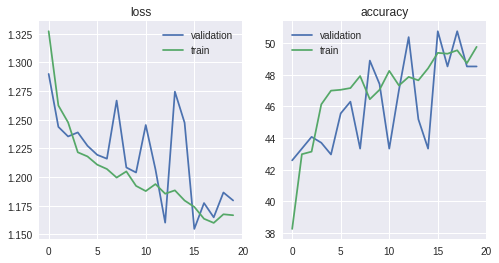

In [132]:
import matplotlib.pyplot as plt
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.002)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.011) #SQ

main_train(epoches = 20)

In [0]:
def load_checkpoint(model, checkpoint_PATH, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_PATH)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
    return model, optimizer

In [134]:
#for num in range(118):
#  num_char = str(num)
#  checkpoint_PATH='checkpoint/ckpt.t' + num_char
#  model_CKPT = torch.load(checkpoint_PATH)
#  net.load_state_dict(model_CKPT['net'])
#  epoch=1
#  test(epoch,test_loader)

checkpoint_PATH='checkpoint/ckpt.t1'
model_CKPT = torch.load(checkpoint_PATH)
net.load_state_dict(model_CKPT['net'])
epoch=1
test(epoch,test_loader)



RuntimeError: ignored

In [0]:
print(model_CKPT['epoch'],model_CKPT['acc'])